In [104]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.models as models
from torchvision import transforms, utils,datasets
import torch.utils.data as data
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdmn
import torch.nn as nn
from sklearn.preprocessing import (MinMaxScaler,StandardScaler,)
import skimage
import matplotlib.pyplot as plt
from collections import OrderedDict
from decimal import Decimal
import sys
import pandas as pd

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
base_dir = "/warehouse/COMPLEXNET/jlevyabi/"
sys.path.append(base_dir + "SATELSES/equirect_proj_test/cnes/python_files/")
from dataset_utils import DigitalGlobeFrance
from model_utils import train, test , load_checkpoint, save_checkpoint

sat_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
census_dir = base_dir + 'REPLICATE_LINGSES/data_files/census_data/'
ua_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
output_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/outputs/esa_URBAN_ATLAS_FR/"#test/

In [3]:
pre_dic = pd.read_csv(output_dir + "../census_data/squares_to_ses.csv" )
pre_dic.dropna(axis=0,subset=["income"],inplace=True)

#scaler = StandardScaler();
#scaler.fit(pre_dic["income"].values.reshape(-1, 1))
#pre_dic["treated_income"] = (pre_dic["income"]<np.median(pre_dic["income"])).astype(int)
#scaler.transform(pre_dic["income"].values.reshape(-1, 1))
#pre_dic["treated_income"] = pre_dic["income"] 

In [4]:
NB_CLASSES = 5
income = pre_dic.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
pre_dic["treated_income"] = x_to_class -1

In [5]:
dic_im2target = {idINSPIRE:inc_vals
                 for idINSPIRE,inc_vals in pre_dic[["idINSPIRE","treated_income"]].values}

In [13]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import Dataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
print("im2city")
pre_city_dic = pd.read_csv(ua_dir + "../../sources/census_cells_city_boundary.csv")
pre_city_dic.dropna(axis=0,subset=["city"],inplace=True)
im2city = {("FR_URBANATLAS_200m_" + idINSPIRE + ".png").lower() : city
           for idINSPIRE,city in pre_city_dic[["idINSPIRE","city"]].values}

im2city


In [7]:
len(set(im2city.keys()))

226442

In [ ]:
w_desired = h_desired = 224
nb_channels = 3
transform = transforms.Compose(
    [transforms.ColorJitter(),transforms.RandomCrop((w_desired,h_desired)),transforms.ToTensor(),])

dg_dataset = DigitalGlobeFrance(root=output_dir, im2target= dic_im2target,im2city=im2city,
                                transform=transform)

100%|██████████| 116/116 [03:37<00:00,  3.78s/it]


In [ ]:
len(dg_dataset)

# Classic: ResNet50 pretrained on ImageNet _( D : 224 x 224 x 3 )_

## Random Cropping

100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


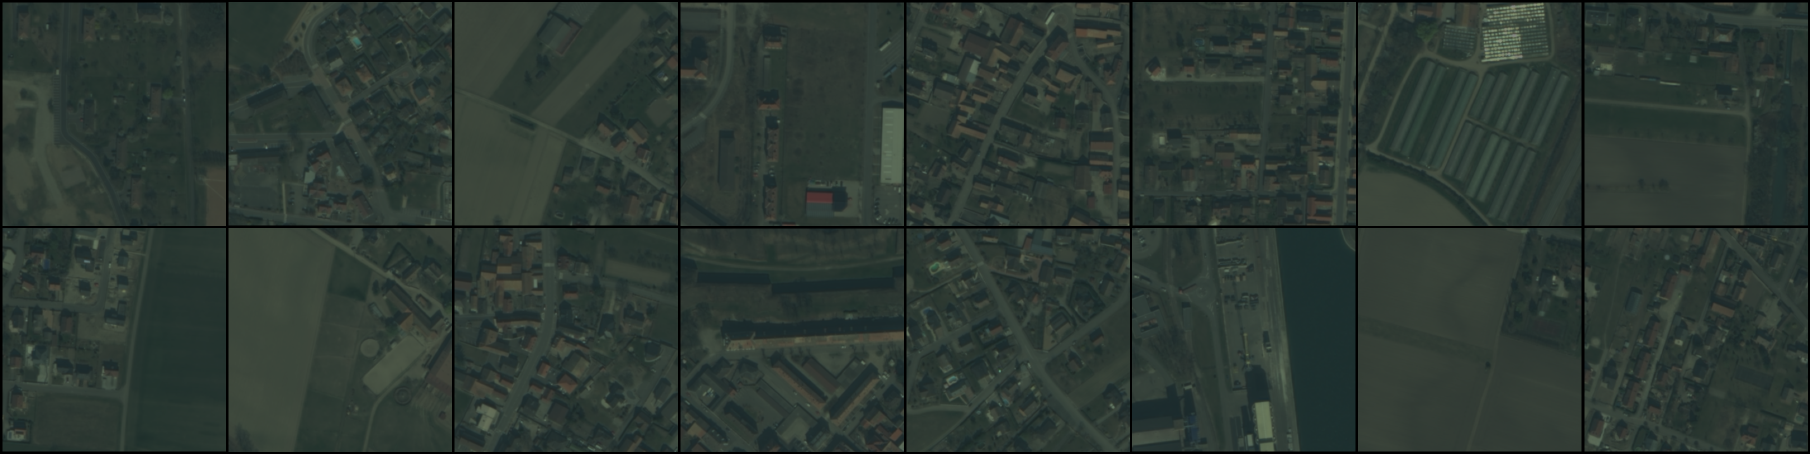

In [10]:
w_desired = h_desired = 224
nb_channels = 3
transform = transforms.Compose(
    [transforms.Resize((w_desired,h_desired)),transforms.ToTensor(),])
dg_dataset = DigitalGlobeFrance(output_dir, dic_im2target, transform=transform)
train_idx, val_idx, test_idx = dg_dataset.train_test_split(frac=0.1)
train_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=train_idx)
val_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=val_idx)
test_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=test_idx)
dataiter = iter(train_loader)
images, classes = dataiter.next()
# show images
x = torchvision.utils.make_grid(images,padding=2);
torchvision.transforms.ToPILImage()(x)

In [11]:
import sklearn.metrics as metrics
lr = 1e-5
momentum = 0.9
weight_decay = 1.0e-3
start_epoch, max_epochs = (0, 2)
gamma = 0.9
ckpt_dir = output_dir + "../model_data/resnet_random_classic_crop/"

model = models.resnet50(pretrained=True)
last_layer_in_fts = list(model.children())[-1].in_features
model.fc = nn.Linear(last_layer_in_fts,out_features=NB_CLASSES,bias=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=gamma, step_size=15)
metrics = metrics.accuracy_score

In [12]:
gpu_images = images.to(device)

In [13]:
outputs = model(gpu_images)

In [18]:
preds_ = []
labels_ = []

In [19]:
preds_.extend(outputs.cpu().detach().numpy().tolist())
labels_.extend(classes.data.cpu().numpy().tolist())

In [21]:
from sklearn import metrics

In [26]:
metrics.accuracy_score(labels_, np.argmax(preds_,axis=1))

0.4375

In [24]:
labels_

[2, 4, 3, 1, 3, 4, 3, 3, 4, 3, 3, 0, 4, 3, 2, 3]

In [25]:
np.argmax(preds_,axis=1)

array([3, 1, 3, 4, 3, 3, 1, 4, 4, 3, 3, 4, 3, 3, 3, 3])

In [ ]:
from model_utils import torch_accuracy
from tensorboardX import SummaryWriter

log_dir = output_dir + "../../python_files/log_files/"
writer = SummaryWriter(log_dir=log_dir + "resnet50_exp0.log")

In [19]:
model.train()  # Set model to training mode
running_loss = 0.0
preds_ = []
labels_ = []
# Iterate over data.
for idx, (batch, label) in tqdmn(enumerate(train_loader)):
    batch, label = batch.to(device), label.to(device)
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward: track history if only in train
    outputs = model(batch)
    loss = criterion(outputs.cuda(), label) # 
    preds_.extend(outputs.cpu().detach().numpy().tolist())
    labels_.extend(label.data.cpu().numpy().tolist())
    running_loss += loss.item() * batch.size(0)
    loss.backward()
    optimizer.step()
    if idx % 5 == 0:
        writer.add_scalar('TRAIN/Loss', loss, 0*len(train_loader)+idx)
        writer.add_scalar('TRAIN/Acc@1', torch_accuracy(label,outputs)[0], 0*len(train_loader)+idx) 
    if idx >20:
        break
writer.close()

In [26]:
test_out = torch.stack((outputs,outputs))
test_lab = torch.stack((label.data,label.data))

In [ ]:
test_loader = DataLoader(dg_dataset, batch_size=1, num_workers=4, sampler=test_idx)
test_score = test(test_loader, model, criterion, device)

## Multiple Cropping + Average

In [20]:
w_desired = h_desired = 224
nb_channels = 3
transform = transforms.Compose(
    [transforms.ColorJitter(),
     transforms.Compose([
         transforms.FiveCrop((w_desired,h_desired)),
         transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
     ])])

dg_dataset = DigitalGlobeFrance(output_dir, dic_im2target, transform=transform)
train_idx, val_idx, test_idx = dg_dataset.train_test_split(frac=0.1)
train_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=train_idx)
val_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=val_idx)
test_loader = DataLoader(dg_dataset, batch_size=16, num_workers=12, sampler=test_idx)

100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


In [21]:
dataiter = iter(train_loader)
images, classes = dataiter.next()

In [9]:
import sklearn.metrics as metrics
lr = 1e-5
momentum = 0.9
weight_decay = 1.0e-3
start_epoch, max_epochs = (0, 2)
gamma = 0.9
ckpt_dir = output_dir + "../model_data/resnet_random_classic_crop/"

model = models.resnet50(pretrained=True)
last_layer_in_fts = list(model.children())[-1].in_features
model.fc = nn.Linear(last_layer_in_fts,out_features=NB_CLASSES,bias=True)
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=gamma, step_size=15)
metrics = metrics.accuracy_score

In [23]:
gpu_images = images.to(device)
bs, ncrops, c, h, w = gpu_images.size()
result = model(gpu_images.view(-1, c, h, w)) # fuse batch size and ncrops
# say result is a 2D tensor
result_averaged = result.view(bs, ncrops, -1).mean(1) # avg over crops

In [24]:
result = model(images.to(device).view(-1, c, h, w)) # fuse batch size and ncrops

In [39]:
metrics(classes,np.argmax(result_averaged.data,axis=1),)

0.125

## Keras Check

In [4]:
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten, Dropout
from keras import backend as K
from keras.optimizers import SGD, Adam
import pandas as pd
import os
import seaborn as sns
from tqdm import tqdm as tqdmn
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import metrics
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

In [3]:
base_dir = "/warehouse/COMPLEXNET/jlevyabi/"
sat_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/esa/URBAN_ATLAS/"
census_dir = base_dir + 'REPLICATE_LINGSES/data_files/census_data/'
ua_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/land_ua_esa/FR/"
output_dir = base_dir + "SATELSES/equirect_proj_test/cnes/data_files/outputs/esa_URBAN_ATLAS_FR/"

scaler = MinMaxScaler()

pre_dic = pd.read_csv(output_dir + "../census_data/squares_to_ses.csv" )
pre_dic.dropna(subset=["income"],inplace=True)
scaler.fit(pre_dic.income.values.reshape(-1, 1))
pre_dic["min_max_income"] = scaler.transform(pre_dic.income.values.reshape(-1, 1))

NB_CLASSES = 5
income = pre_dic.income
class_thresholds = [np.percentile(income,k) for k in np.linspace(0,100,NB_CLASSES +1 )]
x_to_class = np.digitize(income,class_thresholds)
x_to_class[x_to_class==np.max(x_to_class)] = NB_CLASSES
pre_dic["treated_income"] = [ str(y-1) for y in x_to_class ]

image_files = [os.path.join(inter_sat_dir,im_file) for inter_sat_dir in tqdmn(os.listdir(output_dir) )
               for im_file in os.listdir(output_dir + inter_sat_dir) if im_file.endswith(".png")]

100%|██████████| 116/116 [00:02<00:00, 53.04it/s]


In [9]:
pre_dic.head()

,idINSPIRE,income,pov_rate,i_basr,ind_c,nbcar_car,min_max_income,treated_income
0,CRS3035RES200mN2030000E4254200,21190.219512,0.2,0,1.0,16.0,0.627118,3
1,CRS3035RES200mN2030200E4254200,21190.219512,0.2,0,3.0,16.0,0.627118,3
2,CRS3035RES200mN2030400E4253800,21190.219512,0.2,0,2.0,16.0,0.627118,3
3,CRS3035RES200mN2030600E4253400,21190.219512,0.2,0,5.0,16.0,0.627118,3
4,CRS3035RES200mN2030800E4253800,21190.219512,0.2,0,1.0,16.0,0.627118,3


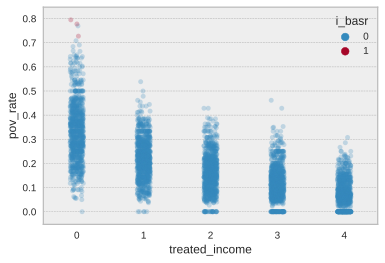

In [17]:
sampled = pre_dic.sample(5000)
sns.stripplot(x="treated_income", y="pov_rate", hue = "i_basr",
              data=sampled, jitter=True,
              alpha=.25, zorder=1);

In [119]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [185]:
from PIL import Image
def myFunc(image):
    image = np.array(image)
    image = 255*(image - np.min(image))/(np.max(image)-np.min(image))
    return image

In [242]:
im_df = pd.DataFrame()
im_df["path2im"] = image_files
im_df["idINSPIRE"] = [k.split("/")[-1].split(".")[0].split("_")[-1] for k in image_files]
full_im_df = pd.merge(pre_dic,im_df,on="idINSPIRE")
full_im_df = full_im_df.sample(frac=1)
train_test_frac = .8
train_test_split = np.floor(full_im_df.shape[0]*train_test_frac).astype(int)
train_im_df = full_im_df.iloc[:train_test_split]
test_im_df = full_im_df.iloc[train_test_split:]


train_datagen = ImageDataGenerator(horizontal_flip=True,validation_split=0.25,
                                   preprocessing_function=myFunc,
                                   rescale=1/255.0,
                                   data_format="channels_last")
test_datagen = ImageDataGenerator(preprocessing_function=myFunc,
                                  rescale=1/255.0,
                                   data_format="channels_last")

In [246]:
train_im_df.shape[0] // 16

25036

In [1]:
25036*16

400576

In [235]:
train_generator = train_datagen.flow_from_dataframe(
        train_im_df.head(),
        directory=output_dir,
        x_col="path2im",
        y_col="treated_income",
        target_size=(224, 224),
        color_mode ="rgb",
        batch_size=16,
        subset="training",
        interpolation="bicubic",
        class_mode='categorical',)

Found 4 images belonging to 4 classes.


In [236]:
test = iter(train_generator)
test_im, test_lab = next(test)

In [237]:
np.max(test_im)

1.0

In [239]:
test_lab

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

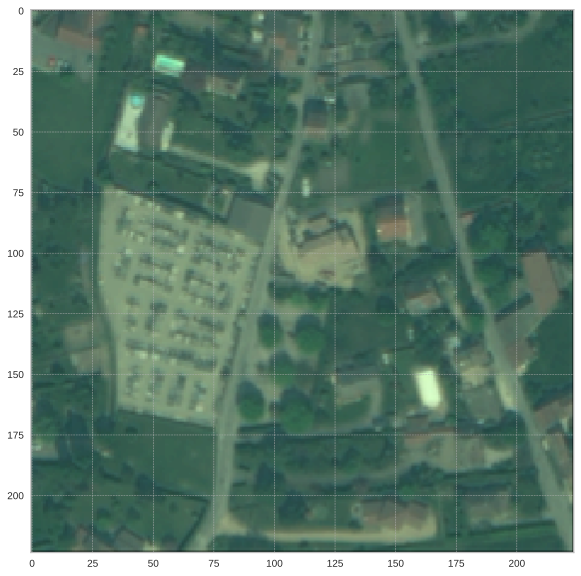

In [238]:
plt.figure(figsize=(10,10))
plt.imshow((test_im[0]));

In [ ]:
val_generator = train_datagen.flow_from_dataframe(
        dataframe=train_im_df,
        directory=output_dir,
        x_col="path2im",
        y_col="treated_income",
        target_size=(224, 224),
        batch_size=16,
        subset="validation",
        class_mode='categorical',)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_im_df,
        directory=output_dir,
        x_col="path2im",
        y_col="treated_income",
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',)

In [73]:
test_datagen?

In [60]:
test_model = ResNet50(include_top=True, weights="imagenet", input_shape=(224,224,3))

In [212]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions,preprocess_input

original = load_img("./cat.jpg", target_size=(224, 224))
print('PIL image size',original.size)
 
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

PIL image size (224, 224)


In [213]:
image_batch = np.expand_dims(preprocess_input(numpy_image/255.0), axis=0)

In [221]:
preprocess_input(image_batch/255.0)

array([[[[-105.23671 , -118.15049 , -125.0554  ],
         [-105.23663 , -118.15042 , -125.055336],
         [-105.23691 , -118.15075 , -125.05564 ],
         ...,
         [-105.236244, -118.150085, -125.05511 ],
         [-105.23637 , -118.15021 , -125.05523 ],
         [-105.236404, -118.15024 , -125.05526 ]],

        [[-105.23721 , -118.15098 , -125.05592 ],
         [-105.23706 , -118.150856, -125.055786],
         [-105.237   , -118.15084 , -125.055756],
         ...,
         [-105.2362  , -118.15004 , -125.05506 ],
         [-105.236404, -118.15024 , -125.05526 ],
         [-105.236435, -118.15027 , -125.05529 ]],

        [[-105.23645 , -118.15019 , -125.055214],
         [-105.236305, -118.150085, -125.05509 ],
         [-105.23635 , -118.15013 , -125.05514 ],
         ...,
         [-105.23623 , -118.15007 , -125.05509 ],
         [-105.23637 , -118.15022 , -125.05517 ],
         [-105.236404, -118.15025 , -125.0552  ]],

        ...,

        [[-105.23668 , -118.150505, -1

In [206]:
predictions = test_model.predict((image_batch),verbose=1)

1/1 [==============================] - 0s 132ms/step


In [207]:
label = decode_predictions(predictions)
print(label)

[[('n03958227', 'plastic_bag', 0.18904969), ('n02123597', 'Siamese_cat', 0.12721333), ('n02124075', 'Egyptian_cat', 0.12720874), ('n02909870', 'bucket', 0.06460524), ('n03223299', 'doormat', 0.058303084)]]


In [ ]:
patience_before_stopping = 5
patience_before_lowering_lr = 3
resnet_checkpt = output_dir + "../model_data/resnet50_baseline_fine_tuned.h5"

base =  ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))
x = Flatten()(base.output)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base.inputs, outputs=x)
model.compile(optimizer=Adam(lr=1e-3),loss="mae",metrics=[r2_keras,"mean_squared_error"])

In [ ]:
model.pre

In [6]:
model.fit_generator(
        train_generator,
        steps_per_epoch=1000,
        epochs=1,
        validation_data=val_generator,
        validation_steps=800,
        workers=10,
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=patience_before_stopping),
                   ModelCheckpoint(filepath=resnet_checkpt, save_best_only=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience_before_lowering_lr)],
)

Epoch 1/1
 746/1000 [=====================>........] - ETA: 4:11 - loss: 0.1330 - r2_keras: -0.3840 - mean_squared_error: 0.0303

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jlevyabi/anaconda3/envs/bv_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-240249f49475>", line 11, in <module>
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience_before_lowering_lr)],
  File "/home/jlevyabi/anaconda3/envs/bv_env/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/jlevyabi/anaconda3/envs/bv_env/lib/python3.6/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/jlevyabi/anaconda3/envs/bv_env/lib/python3.6/site-packages/keras/engine/training_generator.py", line 181, in fit_generator
    generator_output = next(output_generator)
  File "/home/jlevyabi/anaconda3/envs/bv_env/lib/python3.6/site-packages/keras/utils/data_utils.py", line 685, in get
    inp

TypeError: must be str, not list

In [74]:
iter_test = iter(test_generator)
b,c = next(iter_test)

In [82]:
b,c = next(iter_test)
pred_c = model.predict_on_batch(b)

In [89]:
model.predict(b[-2:-1])

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [91]:
model.predict(b[1:2])

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [92]:
np.argmax(pred_c,axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [93]:
np.sum(np.argmax(c,axis=1) == np.argmax(pred_c,axis=1))/64.0

0.09375

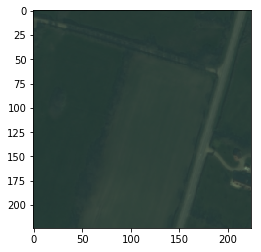

In [94]:
import matplotlib.pyplot as plt
plt.imshow(b[-1]);

In [7]:
model.predict_generator(
        test_generator,
        steps=250,
        workers=10,
        verbose=1
)

250/250 [==============================] - 104s 416ms/step


array([[0.07763485, 0.13809384, 0.13396314, 0.25182235, 0.28954205],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06498056, 0.11307952, 0.11188909, 0.22104001, 0.2865504 ],
       ...,
       [0.08858254, 0.14071389, 0.1397997 , 0.2605725 , 0.30106074],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

# Classic: ResNet50  _( D : w x h x 3 )_

# Experimental: Dilated Convnet

# Experimental: ResNet50 (Multiple Scales)